In [1]:
##############################################################################
#                                                                            #
# Import Libraries                                                           #
#                                                                            #
##############################################################################

import glob                      # Library to read files in a directory
from scipy.stats import pearsonr # Scipy Library
import pandas as pd              # Pandas Library
import matplotlib.pyplot as plt  # Matplotlib Library
import numpy as np               # Numpy Library

In [2]:
##############################################################################
#                                                                            #
# Function: analysis_func                                                    #
#                                                                            #
# This function calculate the p_values, coefficient and number of rows from  #
# a data file crossing it with the life expectancy data                      #
#                                                                            #
# Parameters                                                                 #
# data_path: Archivo a comparar                                              #
# origin: Archivo base contra el que se generarán los coeficientes           #
# yy: Año base para realizar las comparaciones, usa el año en el archivo     #
#     origen                                                                 #
#                                                                            #
# Returns                                                                    #
# coeffs: Coeficient                                                         #
# p_values: The p value                                                      #
# len(joint_data): number of rows used                                       #
# years: List fo years used                                                  #
# set.csv: File with the dataset cleaned and merged                          #
##############################################################################

def analysis_func(data_path, origin, yy):
    
    life_expectancy = pd.read_csv(origin, encoding="ISO-8859-1")[["Countries", yy]]

    #Change column names for clarity
    life_expectancy = life_expectancy.rename(columns = {"Country": "Countries", yy:"Expectancy 2017"})

    try:
        data = pd.read_csv(data_path)
    except:
        try:
            data = pd.read_csv(data_path, encoding="ISO-8859-1")
        except:
            print("Error: It was not possible to read the CSV file.")
            return

    #Inner join to ensure all the countries are the same in both dataframes
    try:
        joint_data = life_expectancy.merge(data, on="Countries", how="inner")
    except:
        print("Error: It was not possible to merge the data. Please check column names on your data file.")

    try:
        for column in joint_data.columns[2:]:
            
            joint_data[column] = pd.to_numeric(joint_data[column])
    except:
        print("Error: Could not convert dataset columns to float values. Please check for missing values in your data.")
        return
    
    # Just in case there's still missing data
    joint_data = joint_data.dropna()
    
    joint_data.to_csv('./Temp/set.csv')
    
    # Create empty lists to keep track of values
    coeffs = []
    p_values = []

    # Get all the years we will be using for our analysis
    years = joint_data.columns[2:]

    # Get the coefficients and the p-values
    for year in years:
        coeff, p = pearsonr(joint_data["Expectancy 2017"], joint_data[year])
        coeffs.append(coeff)
        p_values.append(p)

    return coeffs, p_values, len(joint_data), years

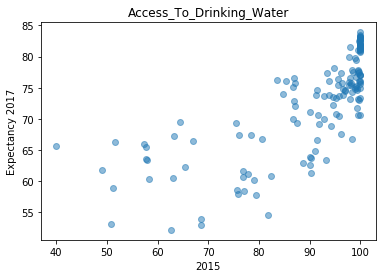

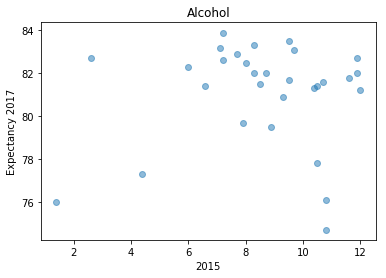

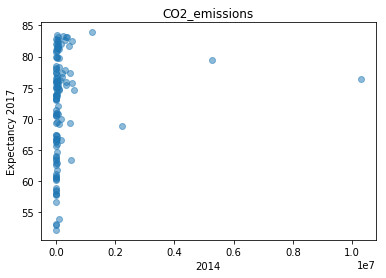

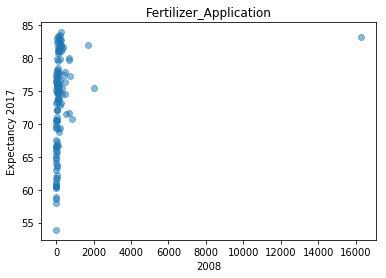

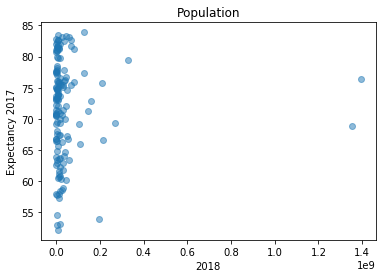

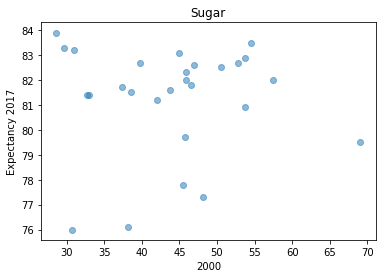

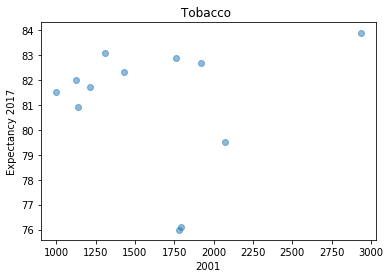

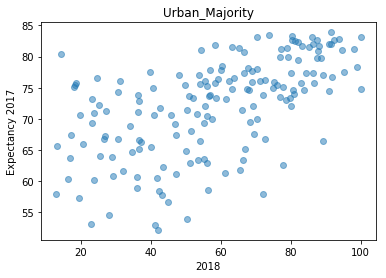

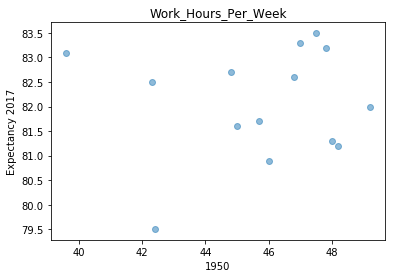

<Figure size 432x288 with 0 Axes>

In [3]:
##############################################################################
#                                                                            #
# Main function                                                              #
#                                                                            #
# The purpouse of this project is to cross the life expectancy index with    #
# other data sets and determine if there are a realtion between both data    #
#                                                                            #
# This function loops through all the files in a single directory and apply  #
# our custom function to analyze the content fo each file and give us the    #
# p value of each set, then use it to create a line plot with a secondary    #
# axis that cross the p_value of the data set and the life expectancy data   #
#                                                                            #
##############################################################################

# List of files
import glob
filesList = glob.glob(".\Resources\*.csv")

# List to store the max values of each topic
maxValuesC = []
maxValuesP = []

# Loop thru files
for files in filesList:
    
    # Get the coeficient, pvalue, lenght of data and years consulted
    coeffs, p_values, len_joint_data, years = analysis_func(files, "Resources/LE/life_expectancy.csv", "2017")
    
    # Set the plot name
    plotName = files[12:len(files)-4]

    # Create a Dataframe to calculate the maximum values
    res = {
        "year": years,
        "Coeficient": coeffs,
        "pVal": p_values
    }
    
    resDF = pd.DataFrame(res)
    
    resDF["Coef_Abs"] = resDF["Coeficient"].abs()
    
    # Calculate the maximum values - Max coeficient
    maxCoef = resDF['Coef_Abs'].max()
    maxCoefData = resDF.loc[resDF['Coef_Abs'] == resDF['Coef_Abs'].max()]['Coeficient'].values[0]
    year = resDF.loc[resDF['Coef_Abs'] == resDF['Coef_Abs'].max()]['year'].values[0]
    pV = resDF.loc[resDF['Coef_Abs'] == resDF['Coef_Abs'].max()]['pVal'].values[0]
    
    # Append the max values to List
    maximumC = {
        "dataSet": plotName,
        "year": year,
        "Coeficient": maxCoefData,
        "pVal": pV
    }
    
    # Calculate the maximum values - Max p value
    pV = resDF['pVal'].max()
    maxCoef =  resDF.loc[resDF['pVal'] == resDF['pVal'].max()]['Coeficient'].values[0]
    year = resDF.loc[resDF['pVal'] == resDF['pVal'].max()]['year'].values[0]
    
    # Load saved set of data
    scat = pd.read_csv('./Temp/set.csv')
    
    # Create axis
    xScatter = scat[year]
    yScatter = scat["Expectancy 2017"]
    
    # Create Scatter plot
    plt.scatter(xScatter, yScatter, alpha=0.5)
    plt.title(plotName)
    plt.xlabel(year)
    plt.ylabel("Expectancy 2017")
    plt.show()
    plt.savefig("./Plots/" + plotName)
    
    # Append the max values to List
    maximumP = {
        "dataSet": plotName,
        "year": year,
        "Coeficient": maxCoef,
        "pVal": pV
    }   
    
    maxValuesC.append(maximumC)
    maxValuesP.append(maximumP)
    

In [4]:
# Show and save Max values per topic
mxp = pd.DataFrame(maxValuesP)

mxp.to_csv("./maxValuePValue.csv")

In [5]:
# Show and save Max values per topic
mxc = pd.DataFrame(maxValuesC)

mxc.to_csv("./maxValueCoeficient.csv")